<a href="https://colab.research.google.com/github/truc-h-nguyen/Toddler-activity-suggestions/blob/main/COCO_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A. Preparation**

Load needed libraries. Then in the next part, we'll load "bowl" dataset, create masks, then create image augmentation for training.

In [ ]:
!pip install fiftyone
import fiftyone.zoo as foz
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
!conda install -c conda-forge keras
!pip install git+https://github.com/qubvel/efficientnet
!pip install git+https://github.com/qubvel/classification_models.git
!pip install git+https://github.com/qubvel/segmentation_models
!pip install git+https://github.com/albu/albumentations
!pip install tta-wrapper

In [ ]:
!pip install -U albumentations

In [ ]:
import albumentations as A
import random

In [ ]:
import os
import shutil
import glob
import random
import cv2

**B. "Bowl" dataset**

In [ ]:
bowl_set = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=["bowl"],
    max_samples=40,
)

In [ ]:
for idx, sample in enumerate(bowl_set):
    if idx > 6:
        break
    img = sample['filepath'] #/root/fiftyone/coco-2017/train/data/000000000590.jpg
    img = mpimg.imread(img)
    useful_detections = [d for d in sample['ground_truth']['detections'] if d['label'] in ['bowl']]
    bbox = useful_detections[0]['bounding_box']

[0.0, 0.03370892018779342, 1.0, 0.9483098591549296]


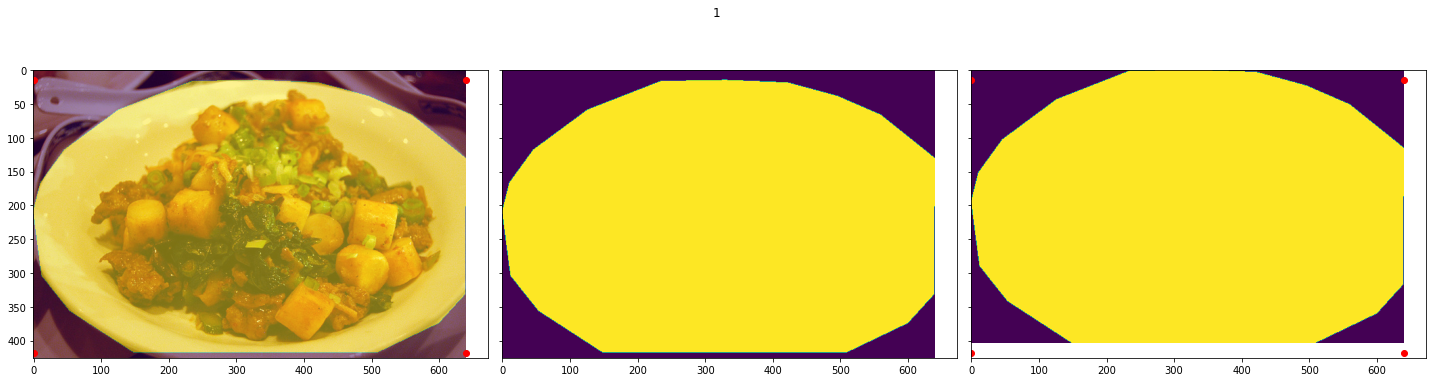

In [ ]:
x,y,w,h = bbox
print(bbox)
mask = np.zeros(img.shape[:2])    
def possible_slices(x,w,y,h):
        xslices = [
                   slice(int(np.floor(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.floor(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
        ]
        yslices = [
                   slice(int(np.floor(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.floor(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
        ]
        return list(product(xslices,yslices))

for detection in range(len(useful_detections)):
      bbox = useful_detections[detection]['bounding_box']
      x,y,w,h = bbox
      all_possible_slices = possible_slices(x,w,y,h)
    
      completed = False
      for xslice, yslice in all_possible_slices:
          if completed: continue
          try:
              mask[yslice, xslice] += useful_detections[detection]['mask']
              completed = True
          except:
              pass

fig, ax = plt.subplots(ncols=3, figsize=(20,6), sharex=True, sharey=True)
fig.suptitle(len(useful_detections))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].scatter(img.shape[1] * np.array([x,x,x+w,x+w]), img.shape[0] * np.array([y,y+h,y,y+h]), color='r')
ax[2].imshow(useful_detections[0]['mask'])
ax[0].imshow(mask, alpha=0.5)
ax[0].scatter(img.shape[1] * np.array([x,x,x+w,x+w]), img.shape[0] * np.array([y,y+h,y,y+h]), color='r')
plt.tight_layout()
plt.show()

**Transform**

In [ ]:
img_size = 200
transform = A.Compose([
    A.Resize(img_size, img_size, p=1),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.9,p=0.2),
    A.Blur(blur_limit=20,p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Transpose(p=0.4),
    A.HueSaturationValue(p=0.5)
])

**Create img and mask array**

In [ ]:
mask_array = []
img_array = []
for idx, sample in enumerate(bowl_set):
  img = sample['filepath']
  img = mpimg.imread(img)
  img_array.append(img)
  useful_detections = [d for d in sample['ground_truth']['detections'] if d['label'] in ['bowl']]
  bbox = useful_detections[0]['bounding_box']
  x,y,w,h = bbox
  mask = np.zeros(img.shape[:2])
  stacked_mask = np.zeros(img.shape[:2])    
  def possible_slices(x,w,y,h):
        xslices = [
                   slice(int(np.floor(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.floor(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
        ]
        yslices = [
                   slice(int(np.floor(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.floor(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
        ]
        return list(product(xslices,yslices))

  for detection in range(len(useful_detections)):
      bbox = useful_detections[detection]['bounding_box']
      x,y,w,h = bbox
      all_possible_slices = possible_slices(x,w,y,h)

      completed = False
      for xslice, yslice in all_possible_slices:
          if completed: continue
          try:
              mask[yslice, xslice] += useful_detections[detection]['mask']
              completed = True
              stacked_mask = cv2.bitwise_or(stacked_mask, mask)
          except:
              pass
  mask_array.append(stacked_mask)

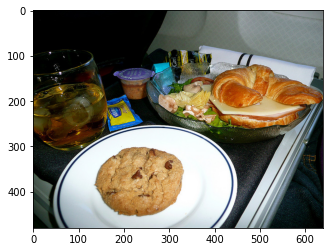

In [ ]:
plt.imshow(img_array[23])

In [ ]:
print(len(mask_array))
print(len(img_array))
print(mask.shape)
print(img.shape)

40
40
(480, 640)
(480, 640, 3)


**Create Data Generator**

In [ ]:
class DataGenerator:
  def __init__(self, my_img_array = img_array, my_mask_array = mask_array, image_size=200, augmentation=False, shuffle = False, batch_size = 1):
    self.image_size = image_size
    self.augmentation = augmentation
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.my_img_array = img_array
    self.my_mask_array = mask_array

  def __getitem__(self, index):
     data_index_min = int(index*self.batch_size)
     data_index_max = int(min((index+1)*self.batch_size, len(self.my_img_array)))

     indexes = self.my_img_array[data_index_min:data_index_max]
     this_batch_size = len(indexes)

     X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
     y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)
     
     for i, sample_index in enumerate(indexes):
          X_sample = cv2.cvtColor(self.my_img_array[index * self.batch_size + i], cv2.COLOR_BGR2BGRA)
          y_sample = cv2.cvtColor(self.my_mask_array[index * self.batch_size + i], cv2.COLOR_BGR2BGRA)

          if self.augmentation is True:
              # Augmentation code
              transformed_imgs = transform(image=X_sample)
              transformed_masks = transform(image=y_sample)
              image_augm = transformed_imgs['image']
              mask_augm = transformed_masks['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
              # divide by 255 to normalize images from 0 to 1
              X[i, ...] = image_augm/255
              y[i, ...] = mask_augm
          else:
              pass
     return X, y
     

In [ ]:
train_generator = DataGenerator(my_img_array = img_array, my_mask_array = mask_array, 
                                image_size=200, augmentation=True, shuffle = False, batch_size = 1)

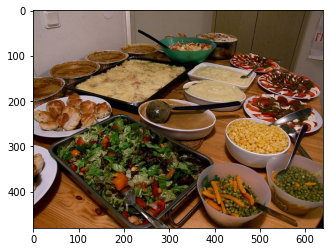

In [ ]:
plt.imshow(train_generator.my_img_array[3])

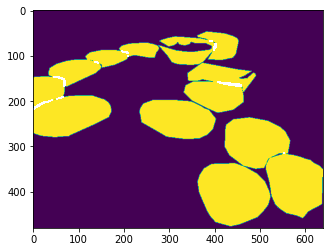

In [ ]:
plt.imshow(train_generator.my_mask_array[3])